# Yale Hydropower Model

## Rocky River Powerplant

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import datetime, calendar
import random

In [2]:
# Load data
stream_flow_data_path = './data/StreamFlowData.csv'
stream_flow_df = pd.read_csv(stream_flow_data_path)
stream_flow_df = stream_flow_df.drop(['Unnamed: 0', 'agency_cd', 'site_no', 'X_00060_00003_cd'], axis=1)
stream_flow_df = stream_flow_df.rename(columns={"Date":"Date", "X_00060_00003":"CFS"})
stream_flow_df['Date'] = pd.to_datetime(stream_flow_df['Date'], format='%m/%d/%Y')

# Filter out 1993-2021
df_stream = stream_flow_df[(stream_flow_df['Date'] >= '1993-01-01') & (stream_flow_df['Date'] < '2022-01-01')]
df_stream = df_stream[~((df_stream.Date.dt.month == 2) & (df_stream.Date.dt.day == 29))]

In [3]:
# df_stream = df_stream.set_index('Date')
CFS = list(df_stream['CFS'])
Dates = list(df_stream['Date'])

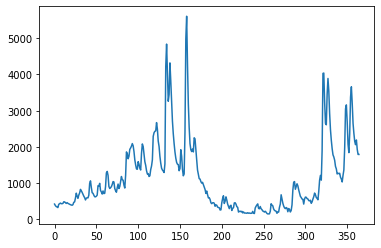

In [4]:
# Plot total CFS for any given year (year_offset)
x_temp = np.arange(0, 365, 1)
year_offset = 9
plt.plot(x_temp, CFS[365 * year_offset:365 + 365 * year_offset])

In [5]:
# Finds local minima (baseline)
def find_minima(s):
    n = len(s)
    minima_loc = [0]
    for i in range(1, n - 1):
        if s[i] <= s[i - 1] and s[i] <= s[i + 1]:
            minima_loc.append(i)
    minima_loc.append(n-1)
    return minima_loc

# Returns baseline function
def interpolate_minima(s, minima):
    new_s = []
    for i in range(len(minima) - 1):
        diff = s[minima[i + 1]] - s[minima[i]]
        interval = diff / (minima[i + 1] - minima[i])
        for j in range(minima[i + 1] - minima[i]):
            new_s.append(s[minima[i]] + j * interval)
    new_s.append(s[-1])
    return new_s

In [6]:
CFS_minima = find_minima(CFS)
CFS_interpolated = interpolate_minima(CFS, CFS_minima)
CFS_years = []
CFS_interpolated_years = []
CFS_net_years = []

counter = 0
base_year = 1993
year_nums = []

for i in range(int(len(CFS) / 365)):
    year = []
    year_interp = []
    net_flow = 0
    
    for j in range(365):
        year.append(CFS[counter])
        year_interp.append(CFS_interpolated[counter])
        net_flow += CFS[counter]
        counter += 1
        
    CFS_years.append(year)
    CFS_interpolated_years.append(year_interp)
    CFS_net_years.append(net_flow)
    year_nums.append(base_year + i)

In [7]:
sf_data = []
for i, y in enumerate(year_nums):
    sf_data.append((y, CFS_net_years[i], CFS_years[i], CFS_interpolated_years[i]))
    
sorted_data = sorted(sf_data, key=lambda x: x[1], reverse=True)

In [8]:
# Print out lowest and highest quartile of years in terms of total CFS 

print(len(sorted_data))
Q1 = []
Q4 = []

for i in range(8):
    Q1.append(sorted_data[-(i + 1)])
    Q4.append(sorted_data[i])

print("\nQ1")
for i in range(8):
    print(Q1[i][0], Q1[i][1])

print("\nQ4")
for i in range(8):
    print(Q4[i][0], Q4[i][1])

29

Q1
2016 373789.0
2002 411245.0
2012 476177.0
2015 498124.0
2001 502345.0
1995 519831.0
2020 522484.0
2017 526530.0

Q4
2011 1122488.0
1996 1037640.0
2018 989207.0
2008 953990.0
2021 874727.0
2003 870683.0
2005 853226.0
2006 841289.0


In [9]:
Q1_ave_baseflow = []
Q1_min_baseflow = []
Q1_max_baseflow = []
Q4_ave_baseflow = []
Q4_min_baseflow = []
Q4_max_baseflow = []

for d in range(365):
    Q1_ave = 0.0
    Q4_ave = 0.0
    for y in range(8):
        Q1_ave += Q1[y][3][d]
        Q4_ave += Q4[y][3][d]
        
    Q1_ave_baseflow.append(Q1_ave / 8.0)
    Q4_ave_baseflow.append(Q4_ave / 8.0)

    Q1_std = np.std([y[3][d] for y in Q1]) * 1.96 / np.sqrt(8)
    Q4_std = np.std([y[3][d] for y in Q4]) * 1.96 / np.sqrt(8)

    Q1_min_baseflow.append(Q1_ave / 8.0 - max(0.0, Q1_ave / 8.0 - Q1_std))
    Q1_max_baseflow.append(Q1_std)
    
    Q4_min_baseflow.append(Q4_ave / 8.0 - max(0.0, Q4_ave / 8.0 - Q4_std))
    Q4_max_baseflow.append(Q4_std)

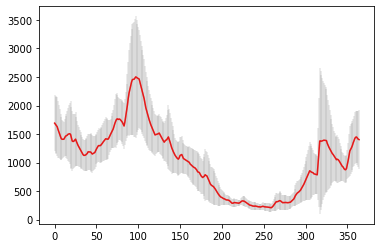

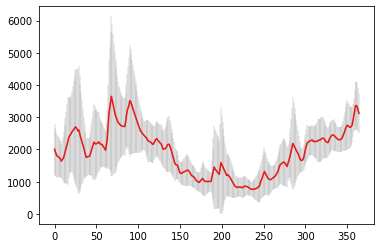

In [10]:
x = np.arange(0, 365, 1)
plt.errorbar(x, Q1_ave_baseflow, yerr=(Q1_min_baseflow, Q1_max_baseflow), color='gray', alpha = 0.2)
plt.plot(x, Q1_ave_baseflow, color='red')
plt.show()

plt.errorbar(x, Q4_ave_baseflow, yerr=(Q4_min_baseflow, Q4_max_baseflow), color='gray', alpha = 0.2)
plt.plot(x, Q4_ave_baseflow, color='red')
plt.show()

In [11]:
year_markers = [90, 91, 92, 92]
print(sum(year_markers))
def residual_dist(quartile):
    residuals = [[], [], [], []]
    for year_data in quartile:
        d = 0
        for i in range(len(year_markers)):
            for j in range(year_markers[i]):
                r = year_data[2][d] - year_data[3][d]
                if r > 0.0:
                    residuals[i].append(r)
                d += 1
    return np.array(residuals)

def maxima_dist(quartile):
    maxima = [0, 0, 0, 0]
    for year_data in quartile:
        d = 0
        for i in range(len(year_markers)):
            for j in range(year_markers[i]):
                if d == 0 or d == 364:
                    d += 1
                    continue
                if year_data[2][d] >= year_data[2][d - 1] and year_data[2][d] >= year_data[2][d + 1]:
                    maxima[i] += 1
                d += 1
    return np.array(maxima)

365


In [12]:
Q1_residuals = residual_dist(Q1)
Q4_residuals = residual_dist(Q4)

Q1_maxima_count = maxima_dist(Q1)
Q4_maxima_count = maxima_dist(Q4)

print(Q1_maxima_count, Q4_maxima_count)

[111 105 147 118] [100  98 110  94]


In [13]:
# sns.kdeplot(Q1_residuals)
# for q in range(len(Q1_residuals)):
#     print(len(Q1_residuals[q]) / 8 / year_markers[q])

In [14]:
# sns.kdeplot(Q4_residuals)
# for q in range(len(Q4_residuals)):
#     print(len(Q4_residuals[q]) / 8 / year_markers[q])

In [15]:
def timeseries(n, s):
    vals = list(np.random.normal(0.0, 0.25, n))
    s_half = s //  2

    # first pass
    mid_vals = []
    rolling_first = [vals[i - s_half] for i in range(n)]
    rolling = sum(rolling_first)
    for i in range(0, n):
        mid_vals.append(rolling / s)
        rolling += vals[(i + s_half + 2 * n) % n] - vals[(i - s_half + 2 * n) % n]
    fv_min = min(mid_vals)
    fv_max = max(mid_vals)
    fv_range = fv_max - fv_min
    for i in range(0, n):
        # final_vals[i] = final_vals[i]  / fv_max
        mid_vals[i] = ((mid_vals[i] - fv_min) / fv_range * 2) - 1.0

    # second pass
    final_vals = []
    rolling_second = [mid_vals[i - s_half] for i in range(n)]
    rolling = sum(rolling_second)
    for i in range(0, n):
        final_vals.append(rolling / s)
        rolling += mid_vals[(i + s_half + 2 * n) % n] - mid_vals[(i - s_half + 2 * n) % n]

    fv_min = min(final_vals)
    fv_max = max(final_vals)
    fv_range = fv_max - fv_min
    for i in range(0, n):
        final_vals[i] = (final_vals[i] - fv_min) / fv_range * 2.0 - 1.0

    return final_vals

# x = np.arange(0, 365, 1)
# ts = timeseries(365, 35)
# print(min(ts), max(ts))
# plt.plot(x, ts)

In [16]:
def gen_data(baseflow, min_flow, max_flow, event_count, noise):
    new_data = []
    d = 0
    ts = timeseries(365, 35)
    for i in range(len(year_markers)):
        for j in range(year_markers[i]):
            new_val = baseflow[d]
            if ts[d] < 0.0:
                new_val += min_flow[d] * ts[d]
            if ts[d] > 0.0:
                new_val += max_flow[d] * ts[d]
            if new_val < 0.0:
                new_val = 0.0
            new_data.append(new_val)
            d += 1
    # new_data = [0] * 365
    # add rain events
    d = 0
    for i in range(len(year_markers)):
        rain_prob = event_count[i] / 8 / year_markers[i]
        for j in range(year_markers[i]):
            r = random.random()
            if r < rain_prob:
                # rain event
                new_data[d] = new_data[d] + noise[i][random.randint(0, len(noise[i]) - 1)]

                # smooth dropoff from rain event
                rolling_window = sum(new_data[d:d+3])
                for k in range(2):
                    if d + 4 + k > 364:
                        break
                    new_data[d + k + 1] = rolling_window / 3
                    rolling_window += new_data[d + 3 + 1 + k] - new_data[d + k]
            d += 1

    return new_data

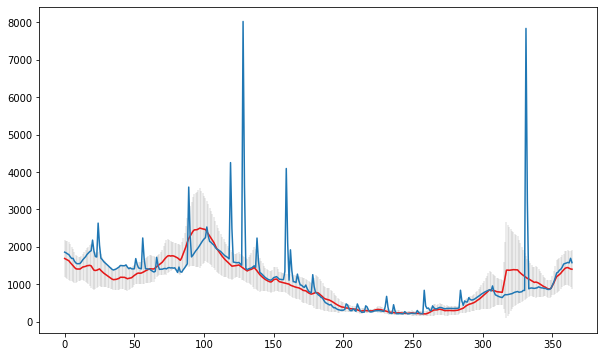

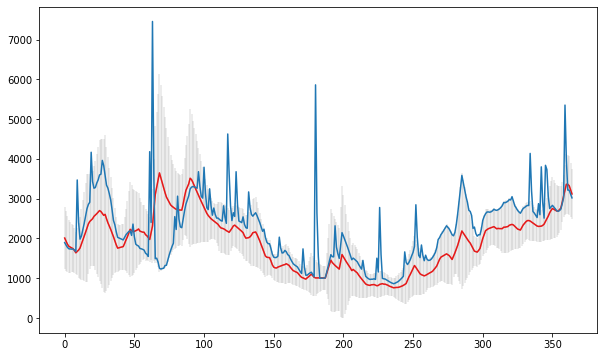

411778.6297631056 816131.6032762611


In [17]:
plt.rcParams['figure.figsize'] = [10, 6] 
x = np.arange(0, 365, 1)

plt.errorbar(x, Q1_ave_baseflow, yerr=(Q1_min_baseflow, Q1_max_baseflow), color='gray', alpha = 0.2)
plt.plot(x, Q1_ave_baseflow, color='red')

Q1_new = gen_data(Q1_ave_baseflow, Q1_min_baseflow, Q1_max_baseflow, Q1_maxima_count, Q1_residuals)
plt.plot(x, Q1_new)
plt.show()


plt.errorbar(x, Q4_ave_baseflow, yerr=(Q4_min_baseflow, Q4_max_baseflow), color='gray', alpha = 0.2)
plt.plot(x, Q4_ave_baseflow, color='red')
Q4_new = gen_data(Q4_ave_baseflow, Q4_min_baseflow, Q4_max_baseflow, Q4_maxima_count, Q4_residuals)
plt.plot(x, Q4_new)
plt.show()

print(sum(Q1_new), sum(Q4_new))

In [18]:
gauge_df = pd.read_csv('gauge_height.csv')
gauge_list = [i[0].split("    ") for i in np.array(gauge_df)]

short_gauge = np.array([[i[3].split(" ")[0], float(i[6].split("   ")[0])] for i in gauge_list])
gauge_dates = np.unique(np.array(short_gauge)[:,0])
short_gauge

array([['2010-01-01', '4.08'],
       ['2010-01-01', '4.08'],
       ['2010-01-01', '4.08'],
       ...,
       ['2020-01-02', '5.01'],
       ['2020-01-02', '5.04'],
       ['2020-01-02', '5.02']], dtype='<U10')

[63.68313784  2.37765023 -1.34000555]


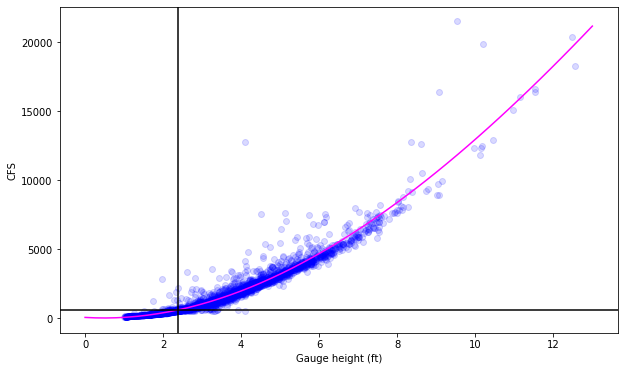

In [19]:
unique_dates, indices = np.unique(short_gauge[:,0], return_index=True)
short_gauge = short_gauge[indices]

CFS_dates = [str(i).split(' ')[0] for i in Dates]
dates_and_CFS = [[CFS_dates[i], CFS[i]] for i in range(len(CFS))]

dates_plot = []
CFS_plot = []
for i in dates_and_CFS:
    if i[0] in short_gauge[:,0]:
        dates_plot.append(i[0])
        CFS_plot.append(i[1])

gauge_plot = []
for i in short_gauge:
    if i[0] in dates_plot:
        gauge_plot.append(float(i[1]))
        
plt.scatter(gauge_plot, CFS_plot, color = 'b', alpha = 0.15)

xp = np.linspace(0, 13)
params = np.polyfit(gauge_plot, CFS_plot, 3)
p = np.poly1d(params)
plt.plot(xp, p(xp), color = 'fuchsia')

plt.axhline(y = 600, color = 'k')

y0 = 600
x0 = (p - y0).roots
print(x0)
plt.axvline(x = x0[1], color = 'k')

plt.xlabel('Gauge height (ft)')
plt.ylabel('CFS')
plt.show()

251.1181315532237
9189.37415303833


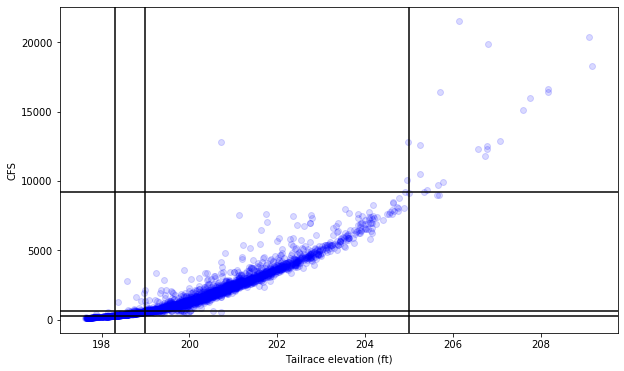

In [20]:
# No pumps may be operated below CFS_min
# One pump may be operated between CFS_min and 600
# Both pumps may be operated above 600 CFS
# No pumps may be operated above CFS_max

tail_gauge_offset = 199 - np.round(x0[1], 2)
gauge_plot_tail = np.array(gauge_plot) + tail_gauge_offset
plt.scatter(gauge_plot_tail, CFS_plot, color = 'b', alpha = 0.15)

plt.axvline(x = 199, color = 'k')
plt.axhline(y = 600, color = 'k')

plt.axvline(x = 198.3, color = 'k')
CFS_min = p(x0[1] - (199 - 198.3))
print(CFS_min)
plt.axhline(y = CFS_min, color = 'k')

plt.axvline(x = 205, color = 'k')
CFS_max = p(x0[1] - (199 - 205))
print(CFS_max)
plt.axhline(y = CFS_max, color = 'k')

plt.xlabel('Tailrace elevation (ft)')
plt.ylabel('CFS')
plt.show()

In [21]:
prices_df = pd.read_csv('daily_average_prices.csv')
daily_price = np.array(prices_df["LMP average day-head price"])

In [54]:
# 250 * 60 * 60 : cubic feet pumped per hour
# 2.4394e8 : square feet surface area of lake

def function(params):
    river_CFS = Q1_new
    lake_level = 428
    running_profit = 0

    pump_time = [params[i] for i in range(365)]
    
    for i in range(365):
        new_level = lake_level + (250 * 60 * 60) / 2.4394e8 * pump_time[i]
        if (new_level < 427 or new_level > 429.5) or (river_CFS[i] < 251.12 and pump_time[i] > 0) or (river_CFS[i] > 9189.37 and pump_time[i] < 0):
            running_profit = 0
            return running_profit
        
        lake_level = new_level
        running_profit = running_profit - daily_price[i] * 13 * pump_time[i]
    
    print(running_profit)
    return -1 * running_profit

In [59]:
import scipy.optimize as opt

x0 = np.zeros(365)
bnds = [(-24, 24)] * 365

res = opt.minimize(function, x0, method='cobyla', bounds = bnds)
# print(res)
res.x

0.0
-1312.4691736
-795.19544624
-954.9013048899999
-435.53270475
-255.09549195
-1249.12132488
-766.3746259
-696.62456084
-300.81025351
-1871.4282859999998
-596.54459527
-644.0494174400001
-1467.2288345
-1766.9504892000002
-429.44235242999997
-836.5596560099999
-644.15287911
-830.22292184
-1413.6874063
-1482.3011658
-1075.21179831
-1042.22768988
-1087.15103822
-1169.91705363
-1348.9022872
-1219.91890605
-779.38006978
-589.48411483
-1137.22024104
-1362.7921736
-1483.3234117000002
-629.69425688
-724.32075274
-637.15583711
-794.00086896
-903.0492094000001
-797.42692302
-871.1020142499999
-333.46065506
-660.26628317
-905.26825623
-686.36138584
-240.14829097999998
-511.21933707
-282.25156921
-602.51802416
-337.31878999
-934.37440343
-661.60194529
-766.73128831
-1099.22677969
-491.61139625
-566.68544348
-727.22767104
-725.9522038599999
-596.97122719
-258.57336102
-737.40674852
-942.3042197399999
-444.25969769999995
-546.19168669
-661.21432065
-426.44007575
-418.82774687000006
-314.53196008
-3

37535.56471632678
37592.39204459942
37592.3920445994
37649.72950503312
37649.72950503312
37707.452985439704
37707.452985439784
37765.636347178384
37765.63634717837
37824.37690908803
37824.376909088045
37883.66757092749
37883.66757092745
37943.539183726105
37943.53918372607
38003.93798740418
38003.93798740416
38064.852440293405
38064.85244029345
38126.28261945299
38126.282619452984
38188.276637003546
38188.2766370035
38250.826253336
38250.82625333601
38313.920680436946
38313.92068043694
38377.59285189379
38377.5928518938
38441.807309793345
38441.807309793374
38506.58433716024
38506.58433716026
38572.05589050002
38572.05589050001
38638.255553865994
38638.25555386597
38705.15988181021
38705.15988181019
38772.760788009815
38772.76078800986
38841.13180605493
38841.13180605495
38910.305600771106
38910.305600771084
38980.308262290106
38980.30826229007
39051.11626261706
39051.1162626171
39122.75327897346
39122.753278973454
39195.28495119666
39195.28495119662
39268.737440019635
39268.7374400196

132685.64997040338
132688.92672913361
132685.6084833627
132688.92672913807
132685.56607175176
132688.92672914357
132685.52275398534
132688.92672913754
132685.47892537038
132688.9267291424
132685.4327401153
132688.92672914476
132685.38596014917
132688.92672914473
132685.33647526297
132688.92672914447
132685.28724965607
132688.92672913792
132685.2376201282
132688.9267291412


array([-3.31114000e-01, -4.17161895e-01,  1.23542533e-01, -8.76158365e-01,
       -1.14295049e+00, -1.69620087e+00, -3.72457346e-02,  3.68400799e-01,
       -1.27275794e+00, -2.80891355e+00, -6.77396091e-01,  2.40352105e-02,
       -5.34861333e-01,  7.89810406e-02, -5.73155792e-01, -1.03047071e-01,
       -6.79138848e-01, -8.06668270e-01, -1.20943028e+00, -1.28692322e+00,
        3.30487207e-01,  3.71376372e-01, -7.48117124e-01, -1.59483473e-01,
       -1.45279631e+00, -8.89789259e-01, -4.03254026e-01, -3.25801561e-01,
       -4.51171875e-01, -4.63504159e-02, -5.80463463e-01,  2.58143791e-02,
       -4.75687929e-03,  2.31987090e-02, -4.16522369e-01, -5.19668812e-01,
       -6.49391569e-02, -5.01358514e-01, -1.13358666e+00,  2.30449526e-02,
        1.47483638e-01, -3.30587905e-01, -1.22972604e+00, -7.24872134e-01,
       -1.48907361e+00, -6.75165817e-01, -7.35243128e-01, -5.68404251e-01,
       -6.83032756e-01, -7.48999743e-01, -1.13171931e+00, -3.98444512e-01,
        2.92440630e-02, -

In [60]:
function(res.x)

132688.92672914476


-132688.92672914476

In [62]:
res.x

array([-3.31114000e-01, -4.17161895e-01,  1.23542533e-01, -8.76158365e-01,
       -1.14295049e+00, -1.69620087e+00, -3.72457346e-02,  3.68400799e-01,
       -1.27275794e+00, -2.80891355e+00, -6.77396091e-01,  2.40352105e-02,
       -5.34861333e-01,  7.89810406e-02, -5.73155792e-01, -1.03047071e-01,
       -6.79138848e-01, -8.06668270e-01, -1.20943028e+00, -1.28692322e+00,
        3.30487207e-01,  3.71376372e-01, -7.48117124e-01, -1.59483473e-01,
       -1.45279631e+00, -8.89789259e-01, -4.03254026e-01, -3.25801561e-01,
       -4.51171875e-01, -4.63504159e-02, -5.80463463e-01,  2.58143791e-02,
       -4.75687929e-03,  2.31987090e-02, -4.16522369e-01, -5.19668812e-01,
       -6.49391569e-02, -5.01358514e-01, -1.13358666e+00,  2.30449526e-02,
        1.47483638e-01, -3.30587905e-01, -1.22972604e+00, -7.24872134e-01,
       -1.48907361e+00, -6.75165817e-01, -7.35243128e-01, -5.68404251e-01,
       -6.83032756e-01, -7.48999743e-01, -1.13171931e+00, -3.98444512e-01,
        2.92440630e-02, -

In [26]:
# lake_level = 428 : 

# l-bfgs-b : 150000
# tnc : 180000 ***
# cobyla : 150000 ****
# slsqp : 140000
# trust-constr : 170000 ***